# Get timeseries of F0s
- Measures every 10 ms
- Needs to be extended to multiple wav files
- Need to add filename somehow as a feature, to keep track

In [2]:
import os
import pandas as pd
import numpy as np
from Tkinter import *
import tkSnack
root = Tk()
tkSnack.initializeSnack(root)

import matplotlib.pyplot as plt
%matplotlib notebook

from sklearn.externals.joblib import Memory
memory = Memory(cachedir="cache")


In [3]:
##from pylab import *
@memory.cache
def getSound(fname_list):
    pitch_list = []
    for item in fname_list:
        utterance = tkSnack.Sound()
        utterance.read(item)
        utterance.convert(channels=1)
        pitch_tuple = utterance.pitch(method="ESPS", windowlength = 0.010)
        pitch_list.append(pitch_tuple)
        utterance.destroy()
    return pitch_list



path = "c:/Python27/qp2_py/question_wav/"
#path = "c:/Python27/qp2_py/data/"
allWavs = os.listdir(path)
#allTxtgridsCOMB = [item for item in allFiles if item[0]== "C"]
#allWavs = [item for item in allFiles if item[0] !="C"]

allPaths = []
for item in allWavs:
    total_path = path+item
    allPaths.append(total_path)


    
#fname = [non_fname, native_fname]
pitch_list = getSound(allPaths)

In [4]:
print len(pitch_list)

20


# To Do:
- In this cell, get all of the name of files for baseline / test v train split

In [5]:
### Make a list of lists of F0 points

all_f0s_list = []
for item in pitch_list:
    just_f0_list = [j[0] for j in item]
    all_f0s_list.append(just_f0_list)


    
print len(all_f0s_list)


## output is [[series of f0s for one file][series of f0s for next file]] etc 




20


## Make TextGrid Objects
- Also needs to be extended to multiple files
- Edit this if you want to look at tiers other than IPU tiers (like Question Tiers)

In [6]:

import tgt
#non_txtgrd = "c:/Python27/qp2_py/txtgrids/COMBINE_p452p453-part2_ch1.textgrid"
#native_txtgrd = "c:/Python27/qp2_py/txtgrids/p226p227-part2_ch2.textgrid"
#all_txtgrids = [non_txtgrd, native_txtgrd]

allTxtPaths = []
path = "c:/Python27/qp2_py/questiontxtgrid/"
allTxtGrids = os.listdir(path)
for item in allTxtGrids:
    allTxtPaths.append(path+item)


checkGrid = allTxtPaths[0]
print len(allTxtPaths)

20


In [7]:
grid_obj= tgt.read_textgrid(checkGrid)
grid_obj.get_tier_names()


[u'BF',
 u'WORD',
 u'LONG_WORD',
 u'LONG_IPUs',
 u'IPU_WORDs',
 u'LAUGHTER',
 u'QUESTIONS']

# Combine TextGrids with F0s
- Has been extended (works)
- QUESTION:  Should we zscore normalize F0 later on, for Legendre coefficient modeling?
    - Yes, maybe.  Let's look at that today (5/31)

In [8]:
#annotations are a list of interval objects
inter = []
segmented_f0s = []

for i in range(len(allTxtPaths)):
    grid_obj = tgt.read_textgrid(allTxtPaths[i])
    word = grid_obj.get_tier_by_name('QUESTIONS')
    ipus = word.annotations
    length = len(ipus)
    for j in range(length):
        start = ipus[j].start_time
        end = ipus[j].end_time
        word = ipus[j].text
        #print start, end, word
        #multiply to get the correct index
        idx_start = int(start*100)
        idx_end = int(end*100)
        #print idx_start, idx_end
        f0s = all_f0s_list[i][idx_start:idx_end]
        entry = (start, end, f0s, word)
        inter.append(entry)
    segmented_f0s.append(inter)
    inter = []

    
    
print len(segmented_f0s)





## make this a loop
#first_word = word.annotations[0]
#print first_word.start_time
#print first_word.end_time
#print first_word.text
#returns a list of lists --> inner list is a tuple of (starttime, endtime, [listofF0series],"textstring")

20


## Code below deals with wavs with no questions
- Made notes of idx of who was removed 
- Still need to handle removing these from the labels, because they will not otherwise be aligned
    - NOT YET DONE AS OF 5/31 (Fix this ASAP)

In [9]:
########### THIS CODE REMOVES SPEAKERS WHO DO NOT HAVE ANY QUESTIONS, KEEPS TRACK OF WHO WAS REMOVED (IDX)#######
removed_idxs=[]
q_segemnted_f0s = []

for i in range(len(segmented_f0s)):
    if len(segmented_f0s[i]) == 0:
        removed_idxs.append(i)
    else:
        q_segemnted_f0s.append(segmented_f0s[i])
    #for thing in item:
     #   print thing[-1]

print removed_idxs
print len(q_segemnted_f0s)

[9, 16, 17, 19]
16


In [6]:
###NOTES ABOUT THIS FUNCTION: 
## Extended for large data lists (2/16/2016)
## log normalizes each F0 point in the IPU, then calculates min, max, and std of the normalized F0s
## also calculates mean and the z-normalized mean of the logF0 points per IPU
## currently (2/15/2016) returns a list of (ipuString, [seconds, minF0, maxF0, std, meanF0, znorm_meanF0, whisper])
## Goal is to output format that's good for sklearn
## NOTE:  For whispered ipus, all values are "NaN"
## NOTE: For one F0 point ipus, min, max, and mean F0 features are log of the F0 point, std&znorm are NaN, whisper = 0


## QUESTIONS FOR ANDREW (2/3/2016):
### z-normalized is returning between 1 and -1, is that okay?
## Is the normalization I'm doing okay
## can I z-score normalize already log normalized f0 means?
## QUESTIONS 2/15/2016
## is my zscore normalization correct?
## handling whisperes and f0 points okay?



#### segmented_f0s

#segmented_f0s is a list [start_time, end_time, [series of F0 measures every 10ms], "ipu_string"]
import scipy
import math
from scipy import stats

feature_set = []
intermediate = []

for i in range(len(segmented_f0s)):
    current = segmented_f0s[i]
    for item in current:
    ## assign text, calculate length    
        txt = str(item[3])
        start_time = item[0]
        end_time = item[1]
        time = end_time-start_time

        f0s = item[2]
        ## log of all valid f0 points
        logF0s = [math.log(f0) for f0 in f0s if f0 !=0]
        ##### if no F0 points
        if bool(logF0s) == False:
            minF0 = "NaN"
            maxF0 = "NaN"
            std = 0
            meanF0 = 0
            znorm_mean = 0
            whisper = 1
        ## if only 1 F0 value    
        elif len(logF0s) == 1:
            oneVal = math.log(logF0s[0])
            minF0 = oneVal
            maxF0 = oneVal
            std = 0
            meanF0 = oneVal
            znorm_mean = 0
            whipser = 0
        
        else:
            minF0 = min(logF0s)
            maxF0 = max(logF0s)
            meanF0 = sum(logF0s)/len(logF0s)
            std = scipy.stats.tstd(logF0s)
            for point in logF0s:
                znorm_mean = (point-meanF0)/std
            whisper = 0
        #print "min:%f, max:%f, std:%f, mean:%f, znormMean:%f" %(minF0, maxF0, std, meanF0, znorm_mean)

        features = [time, minF0, maxF0, std, meanF0, znorm_mean, whisper]
        set_tup = (txt, features)
        intermediate.append(set_tup)
    feature_set.append(intermediate)
    intermediate = []

print len(feature_set)
#for i in range(len(feature_set)):
#    print len(feature_set[i])

50


# Get rid of silence & unicode

In [7]:
done_features = []
inter = []
for ipu in feature_set:
    for features in ipu:
        if features[0] == "silent":
            pass
        else:
            inter.append(features)
    done_features.append(inter)
    inter = []

print len(done_features)
print len(done_features[49])

50
98


# Add Pronouncing Features

In [8]:
####Calculates syllables for each IPU
## NOTE: Assumes words not in the dictionary are all monosyllabic (assumption based on um, mm, and false starts)
### But this is definitely not accurate, there will be names that are wrong too.
## Extended for large data (2/16/2016)

import pronouncing


def getWeirdSyllables(text):
    """Gets syllables count for IPUs that contain OOVs.  NOTE:  OOVs always return monosyllabic"""
    syl_sum = 0
    checkit = text.split()
    for word in checkit:
        valid = pronouncing.phones_for_word(word)
        #print valid
        if valid:
            syl = sum([pronouncing.syllable_count(p)for p in valid[0]])
        else:
            syl = 1
        syl_sum = syl_sum+syl
    return syl_sum


######### 5/19 rewrote this but did not check ##########
@memory.cache    
def getPhones(done_features):
    syl_list = []
    intermediate = []
    for features in done_features:    
        for item in features:
            text = item[0]
            text = text.lower()
            try:
                phones = [pronouncing.phones_for_word(p)[0] for p in text.split()]
                syl = sum([pronouncing.syllable_count(p) for p in phones])

            except IndexError:
                syl = getWeirdSyllables(text)
            intermediate.append(syl)
        syl_list.append(intermediate)
        intermediate = []
    return syl_list


syl_list = getPhones(done_features)

print len(syl_list)
#for i in range(len(syl_list)):
#    print len(syl_list[i])


50


In [9]:
## replaces time with seconds per syllable
## feature_set is now done for a baseline, for many files (3/25/2016)

num_datapoint = len(done_features)

for num in range(num_datapoint):
    for i in range(len(done_features[num])):
        #print done_features[num][i][1]
        length = float(done_features[num][i][1][0])
        ##feature set [each featurelist][each ipu][list of features][seconds]
        syl_num = syl_list[num][i] #get the # of syllables
        #print length
        #print syl_num
        syl_sec =  syl_num/length
        #print "SPACE"
        done_features[num][i][1][0]= syl_sec #replace with syllables per second
        #print done_features[num][i][1][0]




## Build in quick check
#for num in range(len(done_features)):
#   for i in range(10):
#        print done_features[num][i]

## Make IPU based features speaker based features
time, minF0, maxF0, std, meanF0, znorm_mean, whisper

- number ipus per speaker
- avg syls per ipu per speaker
- min f0 per speaker
- max f0 per speaker
- mean f0 per speaker
- mean std per speaker
- avg znorm mean per speaker
- number of whispered ipus
- anything else to add?


In [10]:
syl_per_speaker = []
minf0_per_speaker = []
maxF0_per_speaker = []
meanf0_per_speaker = []
meanStd_per_speaker = []
meanZnorm_per_speaker = []
whispers_per_speaker = []




syl_sum =0
meanf0_sum = 0
meanstd_sum = 0
meanZnorm_sum = 0
whisper_tot = 0

mins = []
maxs = []

[7.692307692307751, 4.778437317477203, 5.349490509827351, 0.17253538730659007, 4.908782448256691, -0.087913055167218049, 0]


for speaker_ipus in done_features:
    num_ipus = len(speaker_ipus)
    for item in speaker_ipus:
        syls = item[1][0]
        #print syls
        min_check =item[1][1]
        if min_check !="NaN":
            mins.append(min_check)
        max_check = item[1][2]
        if max_check != 'NaN':
            maxs.append(max_check)
        meanf0 = item[1][3]
        #print meanf0
        std = item[1][4]
        #print std
        znorm = item[1][5]
        #print znorm
        whisper = item[1][6]
        #print whisper
        ### calculate ######
        syl_sum = syl_sum+syls
        meanf0_sum = meanf0+meanf0_sum
        meanstd_sum = std+meanstd_sum
        meanZnorm_sum = znorm+meanZnorm_sum
        whisper_tot = whisper + whisper_tot
    
    #print maxs
    #calculate & reset
    syl_speaker = syl_sum/num_ipus
    minF0 = min(mins)
    maxF0 = max(maxs)
    meanF0_speaker = meanf0_sum / num_ipus
    meanStd_speaker = meanstd_sum/ num_ipus
    meanZnorm_speaker = meanZnorm_sum/num_ipus
    
    print syl_speaker, minF0, maxF0, meanF0_speaker, meanStd_speaker, meanZnorm_speaker, whisper_tot
    #### put them in out feature vectors
    syl_per_speaker.append(syl_speaker)
    minf0_per_speaker.append(minF0)
    maxF0_per_speaker.append(maxF0)
    meanf0_per_speaker.append(meanF0_speaker)
    meanStd_per_speaker.append(meanStd_speaker)
    meanZnorm_per_speaker.append(meanZnorm_speaker)
    whispers_per_speaker.append(whisper_tot)
    
    #### reset for next run###
    syl_sum =0
    meanf0_sum = 0
    meanstd_sum = 0
    meanZnorm_sum = 0
    whisper_tot = 0
    mins = []
    maxs = []
    

        

4.44973321327 1.64224261516 6.30536981933 0.186416341328 4.60985521903 -0.186543984125 12
3.72622058684 3.97943227708 6.29383921633 0.24772739308 4.80471845269 -0.150966191916 8
3.36641283408 3.97932600384 6.28894537081 0.247534077193 5.01700446871 -0.289292092882 0
2.98266186394 3.98300652934 6.2814539075 0.241352540257 5.1197769973 -0.406997456401 0
3.80374611596 3.97805891338 5.73546626061 0.140937044119 4.73891400954 -0.137249170827 2
4.25264175644 3.9810371983 6.28760406336 0.140054159334 4.75466246913 -0.226808001957 6
3.34536073271 3.97580533462 6.27625287985 0.282529060254 5.07904932492 0.0343588813632 3
3.80302899171 3.98017786923 6.18808400929 0.144883593135 4.7622780289 0.189346890203 5
4.50620292669 3.978749792 6.24570392329 0.100663801898 4.51316860043 0.153678304765 1
3.15604438048 3.98617772288 6.28805106331 0.166906852373 5.13686532372 -0.302337373922 0
2.94851581462 3.9799344615 6.24438423331 0.213999347533 5.09800298321 -0.229734857701 3
3.37318861587 3.97857121024 6.

In [ ]:
### This is where you will make your dataframes 
import pandas as pd
#print len(syl_per_speaker)
#print minf0_per_speaker
#print maxF0_per_speaker
#print meanf0_per_speaker
#print meanStd_per_speaker
#print meanZnorm_per_speaker
#print len(whispers_per_speaker)

In [11]:
import pandas as pd
import re

features = pd.DataFrame(syl_per_speaker, columns=["Syl_Per_Speaker"])
features["minF0"] = minf0_per_speaker
features["maxF0"]=maxF0_per_speaker
features["meanF0"] = meanf0_per_speaker
features["meanStd"] = meanStd_per_speaker
features["meanZnorm"] = meanZnorm_per_speaker
features["Total_Whispered"] = whispers_per_speaker

print features


    Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0          4.449733  1.642243  6.305370  0.186416  4.609855  -0.186544   
1          3.726221  3.979432  6.293839  0.247727  4.804718  -0.150966   
2          3.366413  3.979326  6.288945  0.247534  5.017004  -0.289292   
3          2.982662  3.983007  6.281454  0.241353  5.119777  -0.406997   
4          3.803746  3.978059  5.735466  0.140937  4.738914  -0.137249   
5          4.252642  3.981037  6.287604  0.140054  4.754662  -0.226808   
6          3.345361  3.975805  6.276253  0.282529  5.079049   0.034359   
7          3.803029  3.980178  6.188084  0.144884  4.762278   0.189347   
8          4.506203  3.978750  6.245704  0.100664  4.513169   0.153678   
9          3.156044  3.986178  6.288051  0.166907  5.136865  -0.302337   
10         2.948516  3.979934  6.244384  0.213999  5.098003  -0.229735   
11         3.373189  3.978571  6.281436  0.190771  5.265107   0.370599   
12         4.406870  3.977100  5.94059

In [12]:
##### 4/20 this works now #########

label_csv = pd.read_csv("c:/Python27/qp2_py/labels/devlabels50.csv")



features["labels"] = label_csv["Language"]
print features



    Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0          4.449733  1.642243  6.305370  0.186416  4.609855  -0.186544   
1          3.726221  3.979432  6.293839  0.247727  4.804718  -0.150966   
2          3.366413  3.979326  6.288945  0.247534  5.017004  -0.289292   
3          2.982662  3.983007  6.281454  0.241353  5.119777  -0.406997   
4          3.803746  3.978059  5.735466  0.140937  4.738914  -0.137249   
5          4.252642  3.981037  6.287604  0.140054  4.754662  -0.226808   
6          3.345361  3.975805  6.276253  0.282529  5.079049   0.034359   
7          3.803029  3.980178  6.188084  0.144884  4.762278   0.189347   
8          4.506203  3.978750  6.245704  0.100664  4.513169   0.153678   
9          3.156044  3.986178  6.288051  0.166907  5.136865  -0.302337   
10         2.948516  3.979934  6.244384  0.213999  5.098003  -0.229735   
11         3.373189  3.978571  6.281436  0.190771  5.265107   0.370599   
12         4.406870  3.977100  5.94059

In [13]:


labels = (features[features.columns[7]])
data_features =(features[features.columns[:7]])
print labels

#X_train= x_train[:37]
#X_test = x_train[37:51]

#print X_test


#y_train = labels[:37]
#y_test = labels[37:51]

#print X_train, y_train, X_test, y_test




0      English
1      English
2      English
3      English
4     Mandarin
5     Mandarin
6     Mandarin
7     Mandarin
8      English
9      English
10    Mandarin
11     English
12     English
13     English
14     English
15    Mandarin
16     English
17     English
18     English
19     English
20     English
21     English
22     English
23    Mandarin
24     English
25     English
26     English
27     English
28     English
29    Mandarin
30     English
31    Mandarin
32    Mandarin
33    Mandarin
34    Mandarin
35    Mandarin
36    Mandarin
37    Mandarin
38    Mandarin
39    Mandarin
40    Mandarin
41    Mandarin
42    Mandarin
43    Mandarin
44    Mandarin
45    Mandarin
46    Mandarin
47    Mandarin
48    Mandarin
49     English
Name: labels, dtype: object


## Write baseline features to csv for building models in the future

In [47]:
data_features.to_csv("c:/Python27/qp2_py/features_for_models/baseline_50.csv")
labels.to_csv("c:/Python27/qp2_py/features_for_models/labels_50.csv")

# Let's build some baseline models
5/20/2016


### First model does well but that's because of the train_test split.  CV doesn't do well, but does perform above chance (by a little bit, I think)

In [29]:
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.linear_model import LogisticRegression


X_train, X_test, y_train, y_test = train_test_split(data_features, labels, random_state=0)

logreg = LogisticRegression().fit(X_train, y_train)
score = logreg.score(X_test, y_test)

#classifier = linear_model.LogisticRegression()
#classifier = svm.LinearSVC()
#classifier.fit(X_train, y_train)
#score = classifier.score(X_test, y_test)
predicts = logreg.predict(X_test)

print score, predicts

### LinearSVC yeilds 61% accuracy here, LogReg is 76% (but it's a weird and imbalenced split)
### LinearSVC is probably better for this task

0.692307692308 ['English' 'English' 'Mandarin' 'Mandarin' 'English' 'English' 'Mandarin'
 'English' 'Mandarin' 'English' 'English' 'Mandarin' 'English']


### The mean of the cross validation below is 56% (which is slightly above chance) using 10-fold cross validation
- More accurate, I think
- Though with SVC we get 58%, which is slightly better. 

In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
line_svm = LinearSVC()

scores = cross_val_score(line_svm, data_features, labels, cv=10)
print("cross-validation scores: ", scores)
print scores.mean()

('cross-validation scores: ', array([ 0.5       ,  0.5       ,  0.66666667,  0.66666667,  1.        ,
        1.        ,  0.5       ,  0.5       ,  0.75      ,  0.75      ]))
0.683333333333


### Let's try with a ShuffleSplit cross validation and then fiddle with paramaters
- ShuffleSplit seems like the way to go here (yeilds between 50 and 63% accuracy, hovers mostly between 53-58
- Time to do some parameter tuning, I think.

In [37]:
from sklearn.cross_validation import ShuffleSplit
classifier = LogisticRegression()
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, data_features, labels, cv=shuffle_split)
print shuffle_score.mean()

0.723076923077


### Let's do some motherfuckin' GridSearching of paramaters
- This is actually working pretty well.  If we use SVC (which is a kernel SVM, and SVMs are good) baseline is like 69%

In [43]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}



#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=10)

X_train, X_test, y_train, y_test = train_test_split(data_features, labels, random_state=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 1}
0.837837837838


### The model below performs the best, SVC with C and gamma set from running GridSearch above
- So my acoustic baseline performs around 70%, which is where it should be
- No idea why SVM works better than Linear SVC or LogisticRegession, except that I guess the data here is better divided by curves rather than divides by straight lines?  
- One day, visualizing any of this would be nice


In [46]:
classifier = SVC(C=10, gamma=1)
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, data_features, labels, cv=shuffle_split)
print shuffle_score.mean()

0.7


# Shifting gears: Add polynomial coefficient features

### Still need to do the following:
- Figure out how to add the coefficients as features 
    - talk to Min to figure this out?
    - SPEAKER BASED, NOT IPU BASED (no idea how to do that)
    
- Cluster all coefficients (unsupervised), use number of clusteres as a per speaker feature

- Use all coefficients from native / non-native speakers to train an unsupervised clusterer
    - then for each ipu per speaker get a distance measure to find closest cluster
    - assign ipu to cluster, use total # of each cluster as features (eg. 7 in cluseter 1, 8 in cluster 2)???
        - but how to do that unsupervised - there will be different numbers of clusters
    - replace ipus with distances to find a mean shortest distance to a cluster?
        - that's overgeneralized
    - average distance per cluster? (mean distance for ipus assigned to each cluster)
        - use these distances as features
        - still would need to be supervised clustering probably
        - but distnace would be a better measure of like-ness to native / non-native clusters than just amount

In [10]:
import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)

inter = []
ipu_f0s = []

for wavfile in q_segemnted_f0s:
    for ipu in wavfile:
        if ipu[3] == "silent":
            pass
        else:
            inter.append(ipu)
    ipu_f0s.append(inter)
    inter = []

print len(ipu_f0s)




16
16


In [15]:
#print ipu_f0s[49][74]

In [49]:
########## This code runs 49 speakers but dies on the 50th, write code below to handle one at a time.
import numpy
from numpy.polynomial import Legendre as L
fpath = "c:/Python27/qp2_py/legendre_polynomials/ipu_speaker"
degree = 5
count =0


for k in range(len(ipu_f0s)):
    speakerID = str(k)
    fname = fpath+speakerID+".txt"
    outfile = open(fname, "w")
    for i in range(len(ipu_f0s[k])):
        start = ipu_f0s[k][i][0]
        end = ipu_f0s[k] [i][1]
        f0s = ipu_f0s[k][i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        entry = str(fit)+"\n"
        outfile.write(entry)
    outfile.close()
    print "file %d has been written to %s"%(k, fname)
    #print count
    count = count+1
    fit = None

file 0 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker0.txt
file 1 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker1.txt
file 2 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker2.txt
file 3 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker3.txt
file 4 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker4.txt
file 5 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker5.txt
file 6 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker6.txt
file 7 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker7.txt
file 8 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker8.txt
file 9 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker9.txt
file 10 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_speaker10.txt
file 11 has been written to c:/Python27/qp2_py/legendre_polynomials/ipu_sp

C:\Python27\lib\site-packages\numpy\polynomial\legendre.py:1588: RankWarning: The fit may be poorly conditioned
  warnings.warn(msg, pu.RankWarning)


fpath = "c:/Python27/qp2_py/legendre_polynomials/ipu_speaker"
speaker_ipu = ipu_f0s[49]
fname = fpath+"49"+".txt"
outfile = open(fname, "w")
degree = 5

for i in range(len(speaker_ipu)):
    start = speaker_ipu[i][0]
    end = speaker_ipu[i][1]
    f0s = speaker_ipu[i][2]
    words = speaker_ipu[i][3]
    print i
    x_time = []
    for j in range(len(f0s)):
        x_time.append(start+(0.01*j))
    fit = L.fit(x_time, f0s, degree)
    entry = str(fit)+"\n"
    outfile.write(entry)
outfile.close()
print "file %d has been written to %s"%(k, fname)
#fit = None

In [37]:
### takes lists of IPUs per speaker, creates 7 degree Legendre polynomial coefficients for each IPU,
### result is a matching list with an inner list of legendre transformed ipus

import numpy
from numpy.polynomial import Legendre as L
#sklearn polynomial fitting function
# each polynomial as a feature
#average degree polynomial value per speaker
print len(q_segemnted_f0s)


degree = 7

Xtimes = []
legendre_list = []
inter_l = []
time = []
count = 0
for ipu in ipu_f0s:
    for i in range(len(ipu)):
        start = ipu[i][0]
        end = ipu [i][1]
        f0s = ipu[i][2]
        x_time = []
        for j in range(len(f0s)):
            x_time.append(start+(0.01*j))
        fit = L.fit(x_time, f0s, degree)
        inter_l.append(fit)
        time.append(x_time)
    Xtimes.append(time)
    legendre_list.append(inter_l)
    inter_l = []  
    time = []
    #print count
    count = count+1
    fit = None
        

#print legendre_list[0][:10]

print len(legendre_list)
print len(Xtimes)



16
16
16


In [38]:
######## get the polynomial coefficients ################
## can get individual coefficients with .coef[idx]
####### FOLLOW THE FORMAT BELOW ######
## legendreitem = legendre_list[idx_of_file][ipu]
## degree from above

print len(legendre_list)
x =  legendre_list[0][0]
print x
print x.coef[1]

all_ipu_coefs = []
inter = []
for item in legendre_list:
    for i in range(len(item)):
        ipu = item[i]
        ipu_coefs = [ipu.coef[j] for j in range(degree)]
        inter.append(ipu_coefs)
    all_ipu_coefs.append(inter)
    inter = []
print len(all_ipu_coefs)

16
leg([ 104.14526679   10.92412746  -74.28467759  -16.10219432  -61.93284713
   40.40887178   -3.46289745  -54.46467046])
10.9241274626
16


In [42]:
print len(Xtimes[0])

67


In [53]:
####### WRITE OUT FOR WEISE TO RUN FRECHET DISTANCE MEASURING CODE ON

print len(all_ipu_coefs)
print len(Xtimes)
fpath = "c:/Python27/qp2_py/legendre_polynomials/frechet/questions_AllSpeakers"

def CleanUp(entry):
    entry = str(entry)
    entry = entry.replace(",", " ")
    return entry

for i in range(len(Xtimes)):
    speakerID = str(i)
    fname = fpath+speakerID+".txt"
    outfile = open(fname, "w")
    for j in range(len(Xtimes[i])):
        outfile.write("0:")
        time_entry = tuple(Xtimes[i][j])
        time_entry = CleanUp(entry)
        outfile.write(time_entry)
        outfile.write(":0\n")
        outfile.write("1:")
        coef_entry = tuple(all_ipu_coefs[i][j])
        coef_entry = CleanUp(coef_entry)
        outfile.write(coef_entry)
        outfile.write(":0\n")
    outfile.close()
    print "your file has been written to %s" %(fname)
        

    

16
16
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker0.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker1.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker2.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker3.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker4.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker5.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker6.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker7.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questions_speaker8.txt
your file has been written to c:/Python27/qp2_py/legendre_polynomials/frechet/questio

## Cell below fixes problems with data that had to be removed because there were no questions in the wav
- Below code can edit baselines and baselines with added features as well

In [63]:
## Okay let's fix the labeling / features problem
### It's fixed!  This will 
print removed_idxs
q_labels = pd.read_csv("c:/Python27/qp2_py/labels/questions_labels.csv")
infeatures = pd.read_csv("c:/Python27/qp2_py/features_for_models/baseline_50.csv")

newq = q_labels.drop(removed_idxs)
features = infeatures.drop(removed_idxs)

print newq
print features

[9, 16, 17, 19]
    PID  Group  Gender  Language
0   254     80    Male   English
1   255     80    Male   English
2   256     81  Female   English
3   258     82  Female   English
4   261     83    Male  Mandarin
5   261     83    Male  Mandarin
6   262     84  Female  Mandarin
7   264     85    Male  Mandarin
8   269     87    Male   English
10  273     89  Female  Mandarin
11  279     92  Female   English
12  278     92    Male   English
13  281     93  Female   English
14  282     94  Female   English
15  284     95  Female  Mandarin
18  289     98  Female   English
    Unnamed: 0  Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  \
0            0         4.449733  1.642243  6.305370  0.186416  4.609855   
1            1         3.726221  3.979432  6.293839  0.247727  4.804718   
2            2         3.366413  3.979326  6.288945  0.247534  5.017004   
3            3         2.982662  3.983007  6.281454  0.241353  5.119777   
4            4         3.803746  3.978059  5.735

# Build Clusters (below)

In [18]:
all_ipu_coefs[0]

[[134.62287670303382,
  50.559266976571486,
  -74.922264996782062,
  -31.83351385800896,
  -96.692665255608148],
 [110.49352291622034,
  20.073714945847012,
  -52.201617132375453,
  -7.1509720782014909,
  -57.988108938284725],
 [62.280952308955698,
  -2.6146652827563432,
  -106.62518206498018,
  0.20312388940216025,
  40.923300272872581],
 [72.9111071914447,
  -16.548046147359631,
  -47.768042993946302,
  27.462234799082342,
  -5.8238106529219493],
 [71.929552176824998,
  -21.257097477181034,
  -47.597274757627822,
  0.61060844873547737,
  -41.566454765755722],
 [81.263026195669227,
  2.306494095707003,
  -26.917937417535143,
  7.363505799759734,
  -35.475795093985298],
 [100.78373861778738,
  51.5297891070229,
  13.766015411465439,
  -50.464502071798641,
  57.452038269557313],
 [81.646349581659933,
  15.722287588666948,
  -3.1713694361979607,
  -63.019293425328492,
  45.26611723590004],
 [119.64052248258088,
  -9.4491592478219353,
  -53.246780457361645,
  -10.379064654213622,
  -14.35

In [261]:
import numpy as np
all_L_stacked = np.vstack(all_ipu_coefs)
all_L_stacked.shape

##rows are each legendre coefficient ipu-representation, columns are each individual coefficient

(12290, 12)

In [262]:
all_L_stacked.std(axis=0)  ## use as a feature for per-speaker features, as well
### stds are widly different, so we could really benefit from some normalization, which we do in the next cell

array([ 49.55429528,  52.25462247,  59.64625668,  57.04086584,
        60.97177237,  59.7339769 ,  61.04996404,  60.11421698,
        59.76816567,  58.26186531,  58.84124257,  54.81950316])

In [263]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(all_L_stacked)
scaledLstack = scaler.transform(all_L_stacked)
scaledLstack.std(axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [264]:
from sklearn.decomposition import PCA

pca = PCA(n_components =2)
pca.fit(scaledLstack)
pca_Legendres = pca.transform(scaledLstack)

<IPython.core.display.Javascript object>


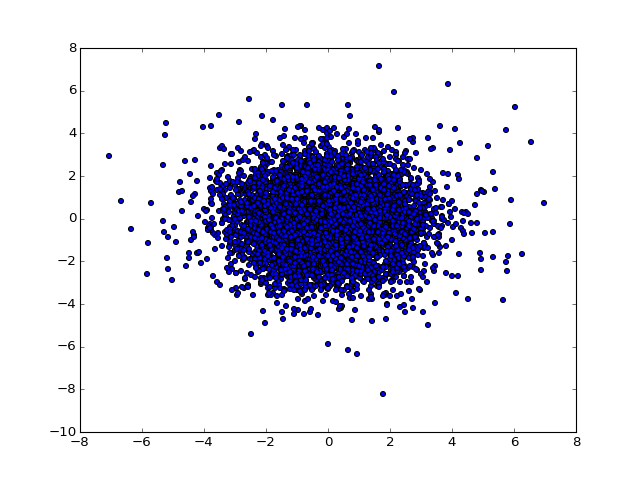

In [265]:
import matplotlib.pyplot as plt
%matplotlib notebook

plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1])

##PCA Scatterplot of first and second principle components (dots are polynomials)

In [266]:
### Cluster the polynomials 
from sklearn.cluster import KMeans
#from sklearn.cluster import AgglomerativeClustering

cluster = KMeans(n_clusters=30)
#cluster = AgglomerativeClustering()

cluster.fit(scaledLstack)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=30, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [25]:
cluster.cluster_centers_
#cluster.labels_

array([[-0.20901296,  0.54233793, -0.10749382,  0.30860231,  0.07332494],
       [ 0.60538193,  0.85566781, -0.13281106, -1.93148159, -1.33568749],
       [ 1.3050045 ,  0.22427828, -1.21028575, -0.14422245, -1.08552061],
       [-0.97828218, -0.7265196 , -0.31620324,  0.82212054,  0.55833139],
       [ 0.11153833,  0.84013187, -1.72444322, -1.88528769,  1.35347905],
       [ 0.51259969, -0.04459363,  0.65642125, -0.29822123, -2.27324442],
       [ 0.91024318,  2.06672665, -0.93146449,  0.15358349,  1.111219  ],
       [ 1.22053922,  0.933489  , -0.38005166,  0.81338441, -0.23446413],
       [-0.09757757,  1.6704067 ,  1.5925158 , -0.17502885, -0.85330158],
       [-1.90367396,  0.03560402,  0.67645599, -0.28363311,  0.53010092],
       [ 0.10370536, -1.49236885, -0.01360023, -0.20417764,  1.10476652],
       [ 0.35122235, -0.20132444, -2.79819822,  0.18536142,  2.07764342],
       [ 0.63676003, -0.8317585 , -0.16412356, -1.02863668, -0.42204907],
       [ 0.71490563,  0.14111952,  0.5

In [368]:
print len(cluster.labels_)
n_clusters = len(cluster.labels_)

12290


<IPython.core.display.Javascript object>


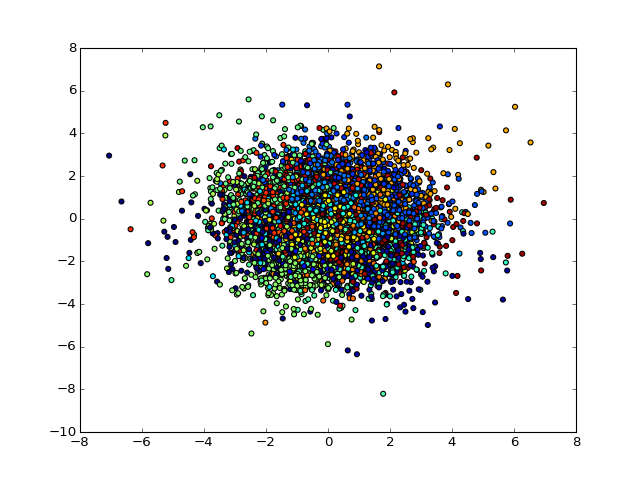

In [267]:
plt.figure()
plt.scatter(pca_Legendres[:,0],pca_Legendres[:,1], c=cluster.labels_)


In [268]:
speaker_ipu_histograms = []
for speaker in all_ipu_coefs:
    scaled_ipu = scaler.transform(speaker)
    ipu_centers = cluster.predict(scaled_ipu)
    histo = np.bincount(ipu_centers, minlength=cluster.n_clusters) #set to to the clusteres we specificied before 
    #histo = np.bincount(ipu_centers, minlength=cluster.n_clusters) #set to to the clusteres we specificied before 
    speaker_ipu_histograms.append(histo / float(histo.sum()))

In [28]:
print speaker_ipu_histograms[0]

[ 0.11235955  0.00873908  0.00124844  0.06117353  0.00499376  0.00124844
  0.00499376  0.00124844  0.01498127  0.06866417  0.01248439  0.00749064
  0.00998752  0.01747815  0.2184769   0.01373283  0.00499376  0.00124844
  0.09238452  0.06741573  0.          0.08489388  0.0062422   0.12609238
  0.00499376  0.00124844  0.00998752  0.00499376  0.01248439  0.02372035]


<IPython.core.display.Javascript object>


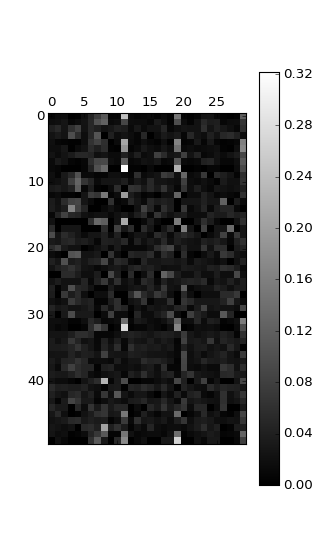

<matplotlib.colorbar.Colorbar instance at 0x274D8058>

In [269]:
speaker_ipu_histograms

plt.matshow(speaker_ipu_histograms,cmap="gray")
plt.colorbar()
#cmap="viridis"

<IPython.core.display.Javascript object>


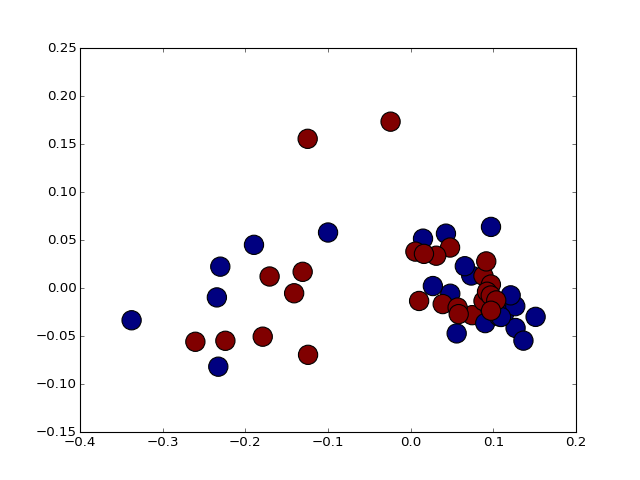

In [270]:
pca = PCA(n_components =2)
pca.fit(speaker_ipu_histograms)
pca_Histograms = pca.transform(speaker_ipu_histograms)
plt.figure()
plt.scatter(pca_Histograms[:,0],pca_Histograms[:,1], c=np.array(labels)=="Mandarin", s=300)

#######histogram scatterplot of what these things look like - needs a list of labels#

In [88]:
np.array(labels) == "Mandarin"

array([False, False, False, False,  True,  True,  True,  True, False,
       False,  True, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False], dtype=bool)

# Add Legendre polynomial cluster histograms as features to baseline
## And then classify

In [271]:
### create feature vectors for each cluster for each speaker out of the histograms
legendre_features = pd.concat([features,pd.DataFrame(speaker_ipu_histograms, columns=["cluster%d" % i for i in range(30)])], axis=1)

In [272]:
only_legendre = pd.DataFrame(speaker_ipu_histograms, columns=["cluster%d" % i for i in range(30)])
#print only_legendre


In [274]:
###add it to the baseline
feature_columns = [col for col in list(legendre_features.columns) if col!= "labels"]
baseline_legendre =(legendre_features[feature_columns])
print baseline_legendre

    Syl_Per_Speaker     minF0     maxF0    meanF0   meanStd  meanZnorm  \
0          4.449733  1.642243  6.305370  0.186416  4.609855  -0.186544   
1          3.726221  3.979432  6.293839  0.247727  4.804718  -0.150966   
2          3.366413  3.979326  6.288945  0.247534  5.017004  -0.289292   
3          2.982662  3.983007  6.281454  0.241353  5.119777  -0.406997   
4          3.803746  3.978059  5.735466  0.140937  4.738914  -0.137249   
5          4.252642  3.981037  6.287604  0.140054  4.754662  -0.226808   
6          3.345361  3.975805  6.276253  0.282529  5.079049   0.034359   
7          3.803029  3.980178  6.188084  0.144884  4.762278   0.189347   
8          4.506203  3.978750  6.245704  0.100664  4.513169   0.153678   
9          3.156044  3.986178  6.288051  0.166907  5.136865  -0.302337   
10         2.948516  3.979934  6.244384  0.213999  5.098003  -0.229735   
11         3.373189  3.978571  6.281436  0.190771  5.265107   0.370599   
12         4.406870  3.977100  5.94059

In [156]:
baseline_legendre.to_csv("c:/Python27/qp2_py/features_for_models/baseline_legendre_k45.csv")

In [36]:
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import train_test_split

In [275]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

#param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

from sklearn.grid_search import GridSearchCV
from sklearn.svm import SVC
grid_search = GridSearchCV(SVC(), param_grid, cv=10)

#from sklearn.linear_model import LogisticRegression
#grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=10)


X_train, X_test, y_train, y_test = train_test_split(baseline_legendre, labels, random_state=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'C': 10, 'gamma': 1}
0.837837837838


In [294]:
#data_features = baseline alone
#baseline_legendres = baseline + legendre

from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
classifier = SVC(C=10, gamma=1)
from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, baseline_legendre, labels, cv=shuffle_split)
print shuffle_score
print shuffle_score.mean()

[ 0.61538462  0.46153846  0.46153846  0.46153846  0.46153846  0.38461538
  0.76923077  0.61538462  0.69230769  0.38461538]
0.530769230769


#### Some basic results from what I think it the best 
##### With SVC classifier
- Just baseline shufflescore mean baseline runs
    - .684, .674, .669, .723, .7
- k3 shufflescore mean baseline plus legendre runs
    - .692, .623, .669, .692, .59
- k7 shufflescore mean baseline plus legendre runs
    - .59, .63, .60, .6, .63
- k45 shufflescore mean baseline plus legendre runs
    - .72, .72, .65, .70, .63
- k60 shufflescore mean baseline plus legendres runs
    - .67, .65, .63, .67, .66
    
  



In [78]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
classifier = LogisticRegression(C = .01)


from sklearn.cross_validation import ShuffleSplit
shuffle_split = ShuffleSplit(50, n_iter= 10, test_size=.25, train_size=.75)
shuffle_score = cross_val_score(classifier, data_features, labels, cv=shuffle_split)
print shuffle_score
print shuffle_score.mean()

[ 0.69230769  0.69230769  0.38461538  0.53846154  0.61538462  0.46153846
  0.61538462  0.30769231  0.46153846  0.76923077]
0.553846153846


#### Results with LogisticRegression
- k7 means baseline 5 runs: 
    - .653, .7, .71, .73, .71
- k7 means baseline + legendre, 5 runs:
    - .69, .63, .76, .67, .72

## some tuning results 
- A higher k of clusters combined with the baseline yeilds results comperable to the baseline alone 
- Baseline + legendre cluster feature are pretty much the same as just baseline when we get to k=45  
    - With a SVC classifier with tuning C = 10, gamma = 1
- After retuning the SVM classifier, just the clustering features yeild results comperable to the baseline alone and the baseline plus the clustering features.
    - with an SVC classifier with tuning C = 1, gamma = 100
    - this tuning tanks baseline and baseline + clustering features
- That's really ineresting, becasue it really demonstrates that these contour features are capturing solid information about the pitch signal
    - But maybe it's information that we already get with the baseline features, and that's frustrating.
    - We want to capture NEW information.
    - And now, I think, is the time to move over and try this with question contours, instead of all IPUs.
